In [1]:
import pandas as pd 
import ast
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading the dataset using datasets library
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset['train'].to_pandas()

# Data cleaning.
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [2]:
df_US = df[(df['job_country'] == 'United States') & (df['job_title_short'] == 'Data Analyst')].dropna(subset='salary_year_avg').copy()

In [4]:
df_US_exploded = df_US.explode('job_skills')

In [9]:
df_US_skills = df_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_US_skills = df_US_skills.rename(columns={'count': 'skill_count', 'median': 'salary_median'})

In [10]:
df_US_skills

,skill_count,salary_median
job_skills,,
sql,2508,91000.0
excel,1808,84392.0
python,1431,97500.0
tableau,1364,92875.0
sas,926,90000.0
...,...,...
couchbase,1,160515.0
chainer,1,100000.0
chef,1,85000.0


In [12]:
total_jobs = len(df_US)
total_jobs

4350

In [14]:
df_US_skills['skill_percentage'] = df_US_skills['skill_count']/total_jobs *100
df_US_demanded_skills = df_US_skills[df_US_skills['skill_percentage'] > 5]

In [15]:
df_US_demanded_skills

,skill_count,salary_median,skill_percentage
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


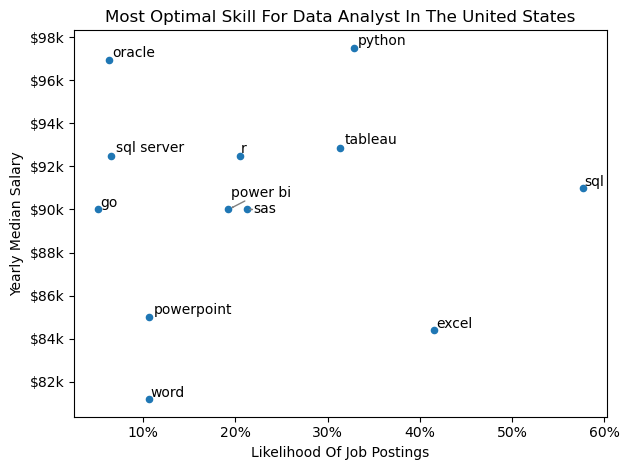

In [34]:
from adjustText import adjust_text

df_US_demanded_skills.plot(kind='scatter', x='skill_percentage', y='salary_median')

texts = []
for i, txt in enumerate(df_US_demanded_skills.index):
    texts.append(plt.text(df_US_demanded_skills['skill_percentage'].iloc[i], df_US_demanded_skills['salary_median'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))

plt.ylabel('Yearly Median Salary')
plt.xlabel('Likelihood Of Job Postings')
plt.title("Most Optimal Skill For Data Analyst In The United States")

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, __: f'{int(x)}%'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, __: f'${int(x/1000)}k'))

plt.tight_layout()
plt.show()

In [55]:
df_tech = df['job_type_skills'].copy()
df_tech = df_tech.drop_duplicates()
df_tech = df_tech.dropna()

tech_info = {}
for row in df_tech:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in tech_info:
            tech_info[key] += value
        else:
            tech_info[key] = value

for key, value in tech_info.items():
    tech_info[key] = list(set(value))

df_tech_info = pd.DataFrame(data=list(tech_info.items()), columns=['tech', 'skills'])
df_tech_info = df_tech_info.explode('skills')
df_tech_info

,tech,skills
0,analyst_tools,visio
0,analyst_tools,cognos
0,analyst_tools,splunk
0,analyst_tools,outlook
0,analyst_tools,msaccess
...,...,...
9,sync,zoom
9,sync,wire
9,sync,google chat
9,sync,unify


In [58]:
df_plot = df_US_demanded_skills.merge(df_tech_info, right_on='skills', left_on='job_skills')

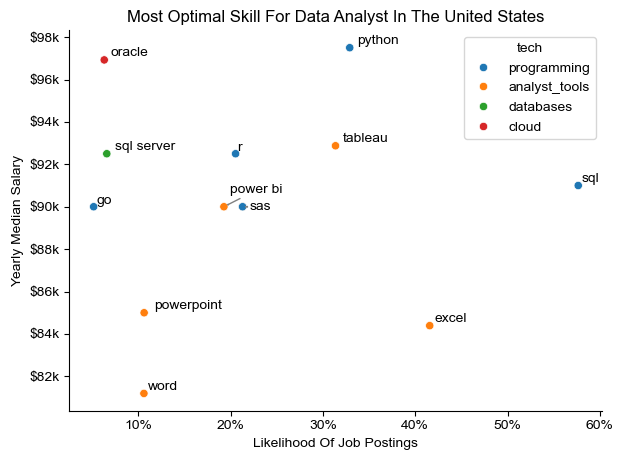

In [66]:
from adjustText import adjust_text

# df_plot.plot(kind='scatter', x='skill_percentage', y='salary_median')
sns.scatterplot(data=df_plot, x='skill_percentage', y='salary_median', hue='tech')

texts = []
for i, txt in enumerate(df_US_demanded_skills.index):
    texts.append(plt.text(df_US_demanded_skills['skill_percentage'].iloc[i], df_US_demanded_skills['salary_median'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))

plt.ylabel('Yearly Median Salary')
plt.xlabel('Likelihood Of Job Postings')
plt.title("Most Optimal Skill For Data Analyst In The United States")

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, __: f'{int(x)}%'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, __: f'${int(x/1000)}k'))
sns.despine()
sns.set_theme(style='ticks')

plt.tight_layout()
plt.show()